In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tests

## 1. Linear

- Prototype: [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- Location in lib: `modules.layers.Linear`

In [3]:
tests.test_linear()

test_linear ... OK


## 2. Batch-normalization

- Prototype: [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d)
- Location: `modules.layers.BatchNormalization`

In [4]:
tests.test_bn()

test_bn ... OK


## 3. Dropout

- Prototype: [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- Location: `modules.layers.Dropout`

In [5]:
tests.test_dropout()

test_dropout ... OK


## 4. Activation functions

### ReLU

- Prototype: [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Location: `modules.activations.ReLU`

### Sigmoid

- Prototype: [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=nn%20sigmoid#torch.nn.Sigmoid)
- Location: `modules.activations.Sigmoid`

### Softmax

- Prototype: [nn.Softmax](http://bit.ly/get3a)
- Location: `modules.activations.Softmax`

### LogSoftmax

- Prototype: [nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=log%20softmax#torch.nn.LogSoftmax)
- Location: `modules.activations.LogSoftmax`

In [6]:
tests.test_activations()

test_activations ... OK


## 5. Sequential

- Prototype: [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- Location: `modules.layers.Sequential`

In [7]:
tests.test_sequential()

test_sequential ... OK


## 6. Loss functions

### MSE

- Prototype: [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- Location: `modules.criterions.MSELoss`

### Cross Entropy

- Prototype: [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Location: `modules.criterions.CrossEntropyLoss`


In [8]:
tests.test_criterions()

test_criterions ... Is mse: True
Is mse: False
Is mse: True
Is mse: False
Is mse: True
Is mse: False
OK


## 7. Optimizers

### SGD

- Prototype: [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Location: `modules.optimizers.SGD`

### Adam

- Prototype: [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- Location: `modules.criterions.CrossEntropyLoss`


In [9]:
tests.test_optimizers()

test_optimizers ... OK


## 8. DataLoader

- Prototype: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- Location: `modules.dataloader.DataLoader`

In [10]:
tests.test_dataloader()

test_dataloader ... OK


# Compare with Pytorch implementation

In [11]:
import numpy as np
import modules as mm
from tqdm.notebook import tqdm

## Test on synthetic data

**Mine implementation**

In [12]:
np.random.seed(42)
X_train = np.random.randn(2048, 8)
X_test = np.random.randn(512, 8)
y_train = np.sin(X_train).sum(axis=1, keepdims=True)
y_test = np.sin(X_test).sum(axis=1, keepdims=True)

train_loader = mm.DataLoader(X_train.astype('float32'), y_train.astype('float32'), batch_size=64, shuffle=True)
test_loader = mm.DataLoader(X_test.astype('float32'), y_test.astype('float32'), batch_size=64, shuffle=False)

model = mm.Sequential(
    mm.Linear(8, 32),
    mm.BatchNormalization(32),
    mm.ReLU(),
    mm.Linear(32, 64),
    mm.Dropout(0.25),
    mm.Sigmoid(),
    mm.Linear(64, 1)
)
optimizer = mm.Adam(model, lr=1e-2)
criterion = mm.MSELoss()

In [13]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))

for epoch in pbar:
    train_loss, test_loss = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()

        train_loss += loss * X_batch.shape[0]

    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss * X_batch.shape[0]

    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss})

Widget Javascript not detected.  It may not be installed or enabled properly.


**Pytorch**

In [14]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Linear(8, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.Dropout(0.25),
    nn.Sigmoid(),
    nn.Linear(64, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [15]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))

for epoch in pbar:
    train_loss, test_loss = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:
        
        X_batch = torch.from_numpy(X_batch)
        y_batch = torch.from_numpy(y_batch)
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        train_loss += loss * X_batch.shape[0]

    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = torch.from_numpy(X_batch)
        y_batch = torch.from_numpy(y_batch)
        
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss = loss.item()
        test_loss += loss * X_batch.shape[0]

    train_loss /= train_loader.num_samples()
    test_loss /= test_loader.num_samples()
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss})

Widget Javascript not detected.  It may not be installed or enabled properly.


## MNIST Classification

In [16]:
import pandas as pd

mnist_df = pd.read_csv('digit-recognizer/train.csv')

In [17]:
mnist_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = mnist_df.drop(['label'], axis=1)
y = mnist_df['label']

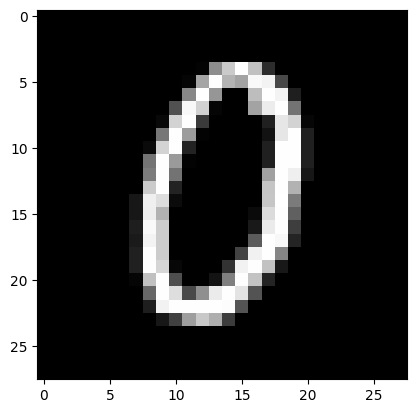

In [19]:
import matplotlib.pyplot as plt

plt.imshow(X[5:6].values[0].reshape((28, 28)), cmap='gray')

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

**Mine implementation**

In [13]:
0.85 ** (30/1440)

0.9966199143634417